In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

/Users/zhanghq/miniconda3/envs/vae-volsurface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 17:35:02,296	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-18 17:35:02,402	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [3]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

[2025-04-18 17:35:18] [INFO] src.utils.data_helper (49) : Bad data - Filtered 1110238 rows, Retained sample 76.67%
[2025-04-18 17:35:31] [INFO] src.utils.data_helper (62) : Consecutive trading stats completed
[2025-04-18 17:35:32] [INFO] src.utils.data_helper (85) : Consecutive trading - Filtered 2341950 rows, Retained sample 35.81%
[2025-04-18 17:35:32] [INFO] src.utils.data_helper (90) : Moneyness calculation completed


In [4]:
model_name = "vae_pw_ii"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 8

In [5]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [6]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-18 17:35:32] [INFO] src.train (60) : Using device: mps


In [7]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [8]:
mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

In [9]:
df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

In [10]:
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['moneyness', 'ttm']].values, dtype=torch.float32)
pw_grid_data[:, 1] = pw_grid_data[:, 1]
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [11]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [12]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-18 17:35:35] [INFO] train (3) : Epoch 1/8
[2025-04-18 17:36:55] [INFO] src.train (179) : Loss: 0.0053
[2025-04-18 17:36:55] [INFO] train (3) : Epoch 2/8
[2025-04-18 17:38:15] [INFO] src.train (179) : Loss: 0.0040
[2025-04-18 17:38:15] [INFO] train (3) : Epoch 3/8
[2025-04-18 17:39:36] [INFO] src.train (179) : Loss: 0.0039
[2025-04-18 17:39:36] [INFO] train (3) : Epoch 4/8
[2025-04-18 17:40:58] [INFO] src.train (179) : Loss: 0.0038
[2025-04-18 17:40:58] [INFO] train (3) : Epoch 5/8
[2025-04-18 17:42:18] [INFO] src.train (179) : Loss: 0.0037
[2025-04-18 17:42:18] [INFO] train (3) : Epoch 6/8
[2025-04-18 17:43:39] [INFO] src.train (179) : Loss: 0.0037
[2025-04-18 17:43:39] [INFO] train (3) : Epoch 7/8
[2025-04-18 17:44:59] [INFO] src.train (179) : Loss: 0.0037
[2025-04-18 17:44:59] [INFO] train (3) : Epoch 8/8
[2025-04-18 17:46:19] [INFO] src.train (179) : Loss: 0.0036


In [18]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

## Test generation

In [19]:
from src.volsurface import VAEPWVolSurface

In [20]:
trainer.load_model("params/vae_pw_ii.pth")

[2025-04-18 17:46:25] [INFO] src.train (136) : Model loaded from params/vae_pw_ii.pth


In [21]:
vaevsurf = VAEPWVolSurface(trainer.model)

In [147]:
vaevsurf.refresh()
vaevsurf.predict_grid(delta_grid, maturity_grid)

array([[0.24309017, 0.17316204, 0.15830885, 0.15665081, 0.15600517,
        0.15530546, 0.15494573, 0.15477233],
       [0.24255277, 0.17644392, 0.16212612, 0.16043572, 0.15977743,
        0.15906405, 0.15869719, 0.15852037],
       [0.24183343, 0.18003899, 0.16675147, 0.16502236, 0.16434895,
        0.16361909, 0.16324383, 0.16441867],
       [0.2408874 , 0.18287918, 0.17233874, 0.17056036, 0.16986895,
        0.16936429, 0.1724665 , 0.17447984],
       [0.23969758, 0.18621263, 0.17903091, 0.17719606, 0.1767282 ,
        0.18142751, 0.18469287, 0.18681017],
       [0.23818989, 0.18922028, 0.18590781, 0.18711944, 0.19086982,
        0.1958557 , 0.1993175 , 0.20156097],
       [0.2364971 , 0.19161582, 0.19188058, 0.20130925, 0.20603186,
        0.21220367, 0.2162369 , 0.21861884],
       [0.24263224, 0.19170795, 0.20544936, 0.21618533, 0.2211603 ,
        0.22765535, 0.23205659, 0.23485224],
       [0.29252073, 0.19387123, 0.22384946, 0.24416691, 0.25350606,
        0.2660918 , 0.274938

<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

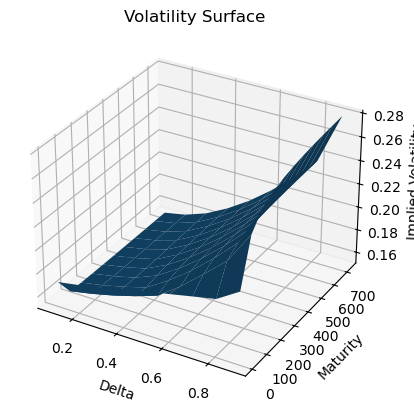

In [155]:
vaevsurf.refresh()
vaevsurf.plot(maturity_range=(7, 720))